In [129]:
import warnings

import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
from shapely import Point

from ocr import catalog
from ocr.config import OCRConfig

warnings.filterwarnings('ignore')

In [2]:
config = OCRConfig(storage_root='/tmp/ocr-testing')
config

OCRConfig(environment=<Environment.QA: 'qa'>, version=None, storage_root='/tmp/ocr-testing', vector=VectorConfig(environment=<Environment.QA: 'qa'>, version=None, storage_root='/tmp/ocr-testing', prefix='intermediate/fire-risk/vector/qa', output_prefix='output/fire-risk/vector/qa', debug=False), icechunk=IcechunkConfig(environment=<Environment.QA: 'qa'>, version=None, storage_root='/tmp/ocr-testing', prefix='output/fire-risk/tensor/qa/ocr.icechunk', debug=False), chunking=<POLYGON ((-64.054 22.428, -64.054 52.482, -128.387 52.482, -128.387 22.428,...>, coiled=CoiledConfig(tag={'Project': 'OCR'}, forward_aws_credentials=False, spot_policy='spot_with_fallback', region='us-west-2', ntasks=1, vm_type='m8g.2xlarge', scheduler_vm_type='m8g.2xlarge'), debug=False)

In [6]:
import icechunk

ds_dict = {}
setups = ['production']  # ,'qa']
version = '0.7.0'
for setup in setups:
    storage = icechunk.s3_storage(
        bucket='carbonplan-ocr',
        prefix=f'output/fire-risk/tensor/{setup}/v{version}/ocr.icechunk',
        from_env=True,
    )
    repo = icechunk.Repository.open(storage)
    session = repo.readonly_session('main')

    ds_dict[setup] = xr.open_zarr(session.store, consolidated=False, zarr_format=3)

In [62]:
tracts_dict = {}
for statistic in ['corr_low', 'low_bias', 'high_bias']:
    tracts_dict[statistic] = gpd.read_file(f'{statistic}_tracts_{version}.shp', index_col=0)

/Users/ori/code/ocr/.pixi/envs/default/lib/python3.13/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option INDEX_COL
  return ogr_read(
/Users/ori/code/ocr/.pixi/envs/default/lib/python3.13/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option INDEX_COL
  return ogr_read(
/Users/ori/code/ocr/.pixi/envs/default/lib/python3.13/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option INDEX_COL
  return ogr_read(


In [27]:
bounding_boxes = {
    'leavenworth': [slice(47.61, 47.57), slice(-120.69, -120.61)],
    'bethany': [slice(48, 47.5), slice(-121.8, -121.4)],
}

In [40]:
states = gpd.read_file('s3://carbonplan-risks/shapefiles/cb_2018_us_state_20m.zip')
states = states[~(states['STUSPS'].isin(['AK', 'PR', 'HI']))]

In [64]:
var_name_dict = {'corr_low': 'low correlation', 'high_bias': 'high bias', 'low_bias': 'low bias'}

In [109]:
def plot_regions_carbonplan_scott(ds, bounding_box, title, points_to_plot=None):
    fig, axarr = plt.subplots(ncols=3, figsize=(15, 5))
    ax = ds.wind_risk_2011.plot(ax=axarr[0])
    axarr[0].set_title('CarbonPlan')
    ds.USFS_RPS.plot(ax=axarr[1], vmin=ax.get_clim()[0], vmax=ax.get_clim()[1])
    axarr[1].set_title('Scott (2024)')
    states.plot(ax=axarr[2], color='white', edgecolor='black')
    if points_to_plot is None:
        gpd.GeoSeries(Point(bounding_box[1].start, bounding_box[0].start)).set_crs(
            'EPSG:4326'
        ).centroid.plot(ax=axarr[2])
    else:
        points_to_plot.centroid.plot(ax=axarr[2])
    plt.suptitle(title)
    plt.tight_layout()

# Low correlation

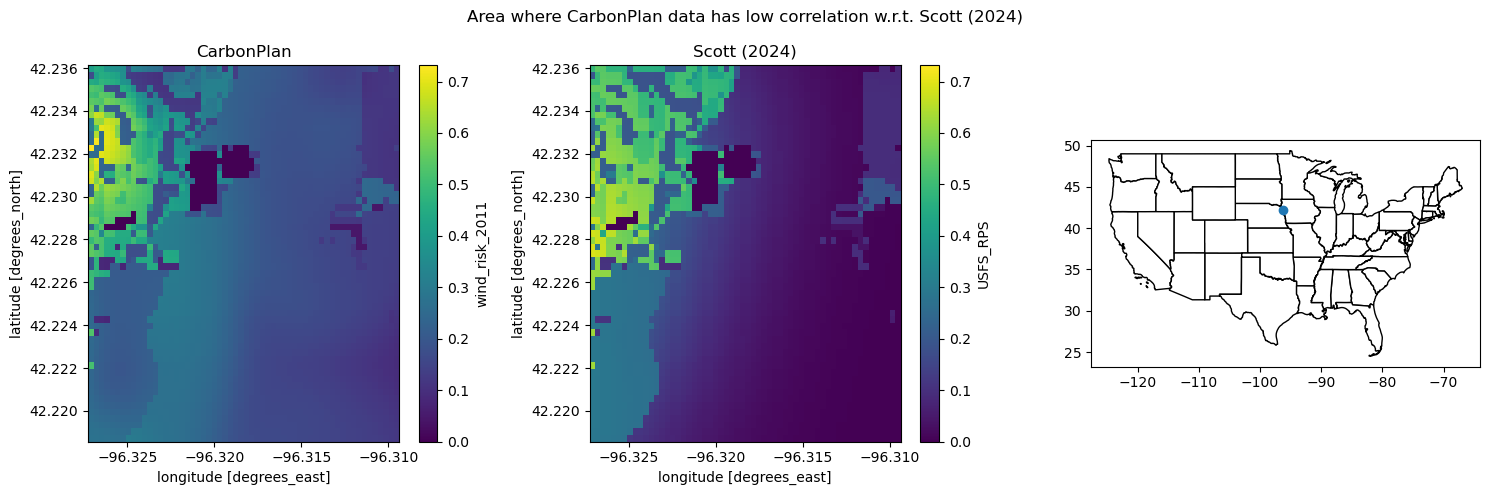

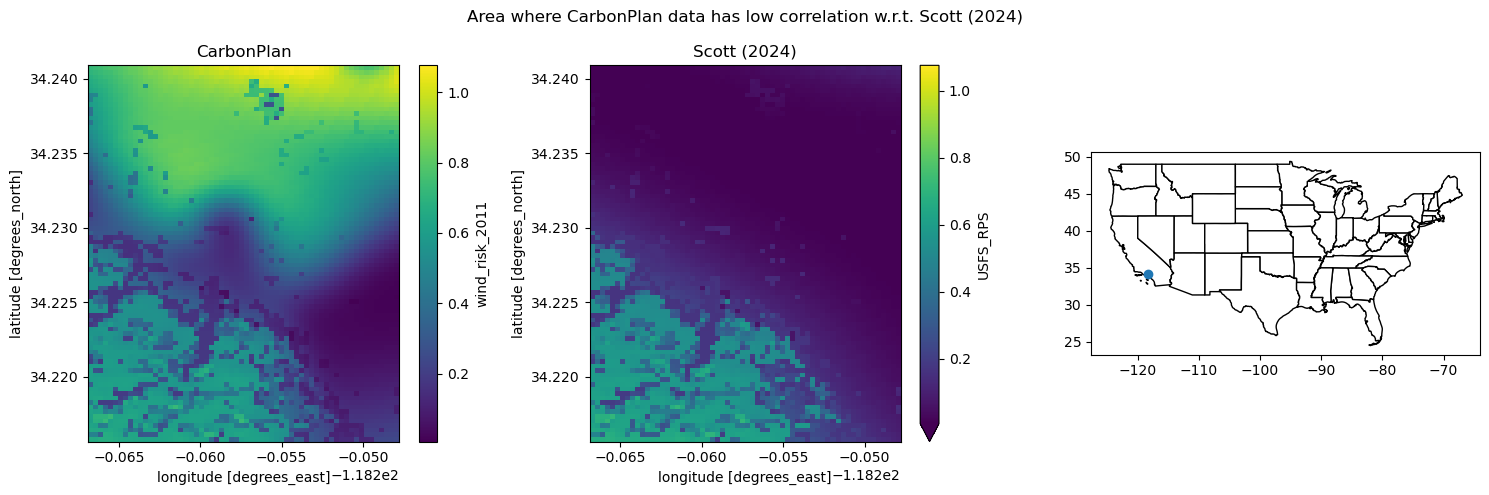

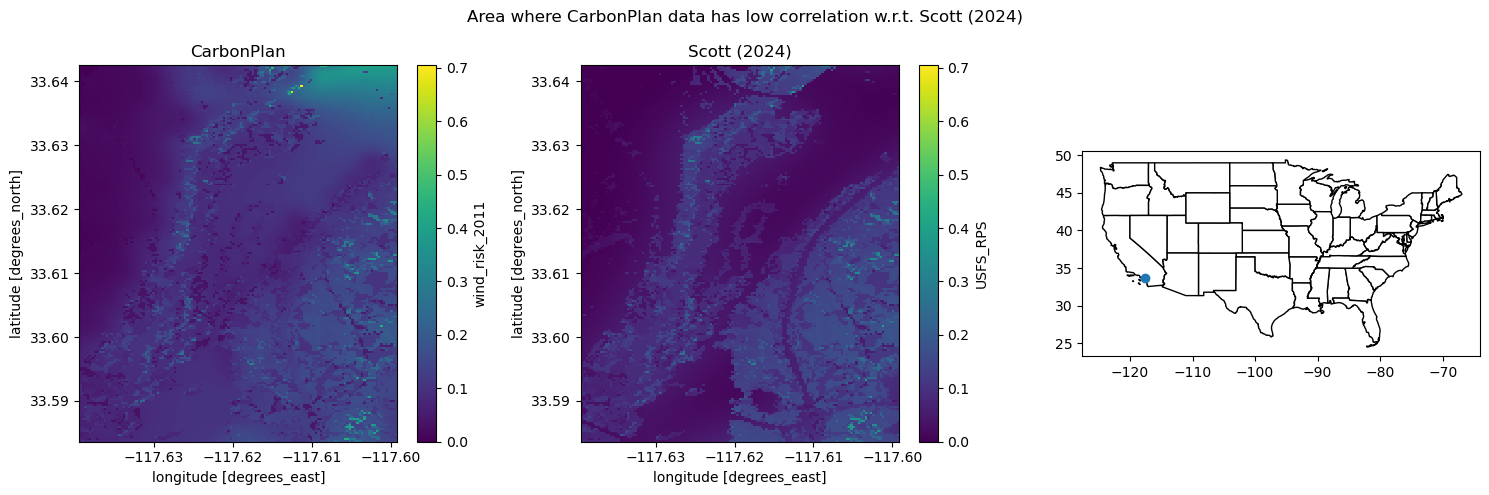

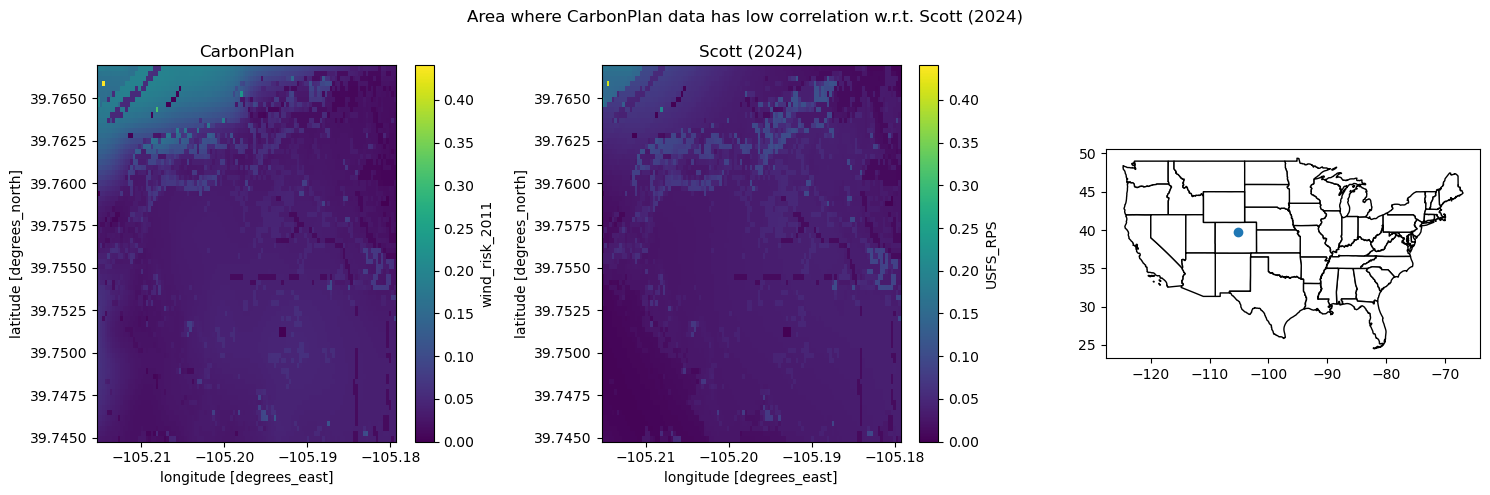

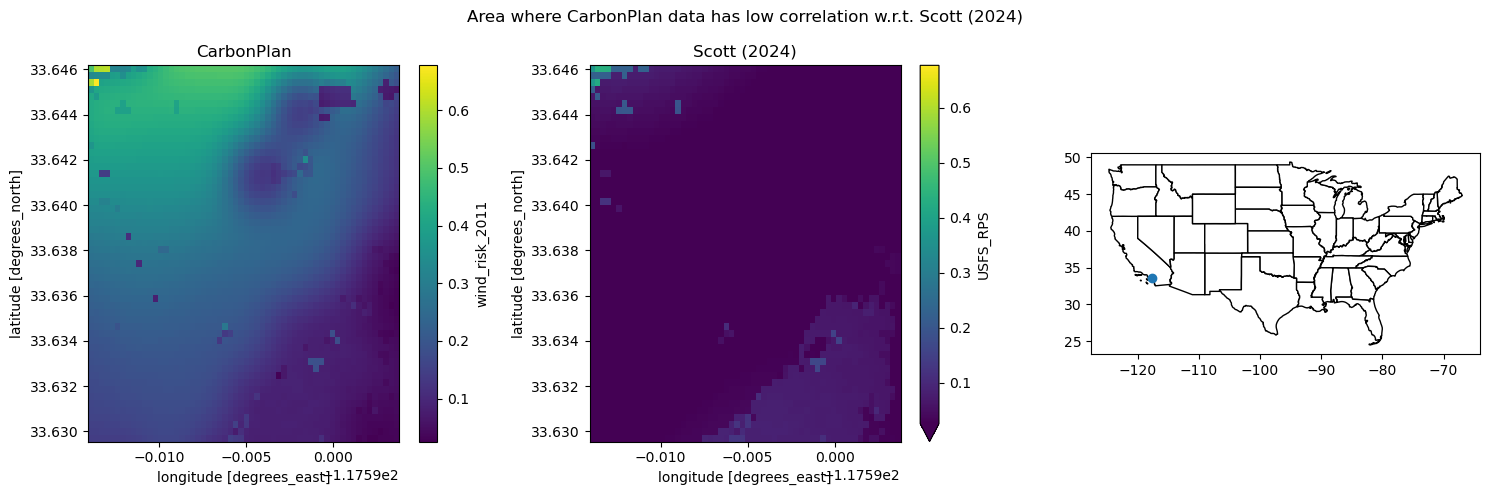

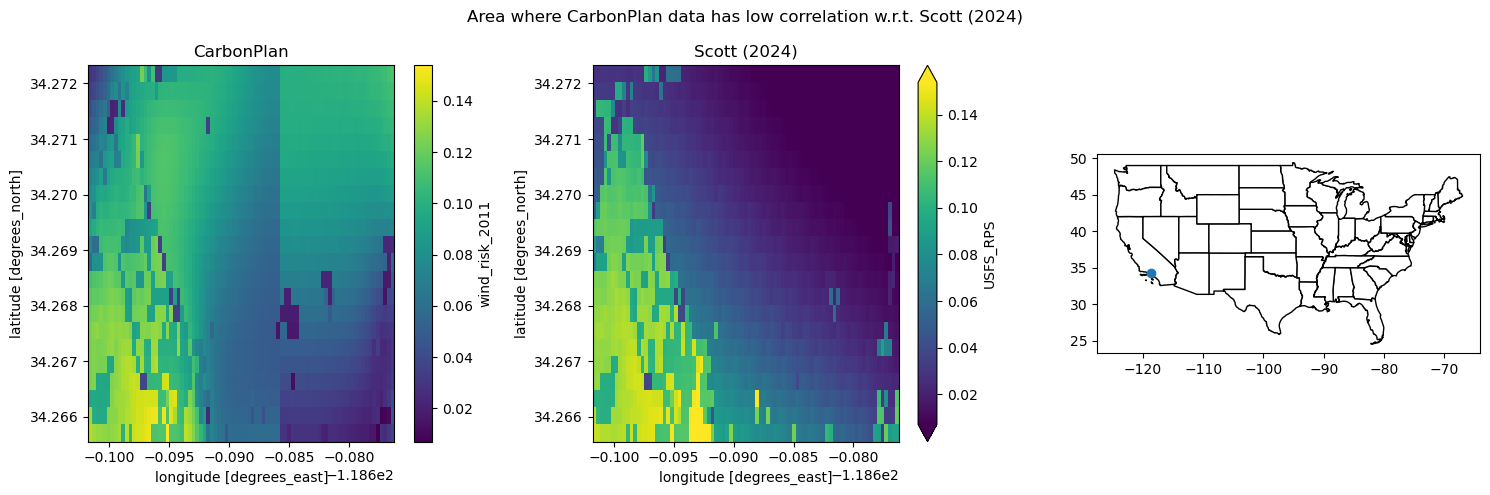

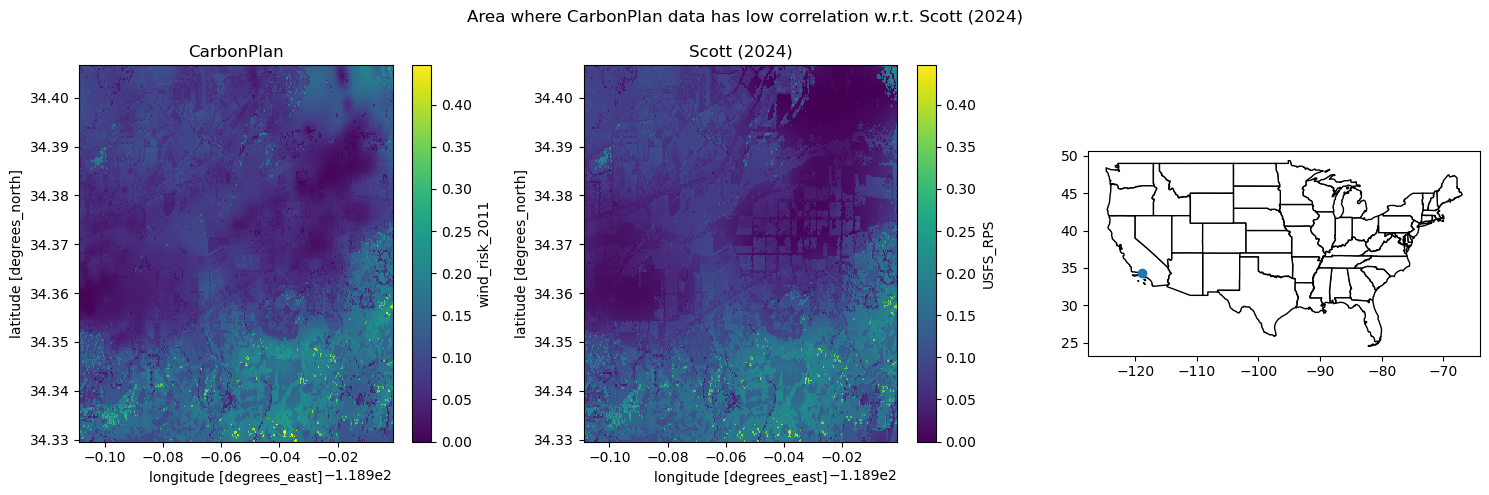

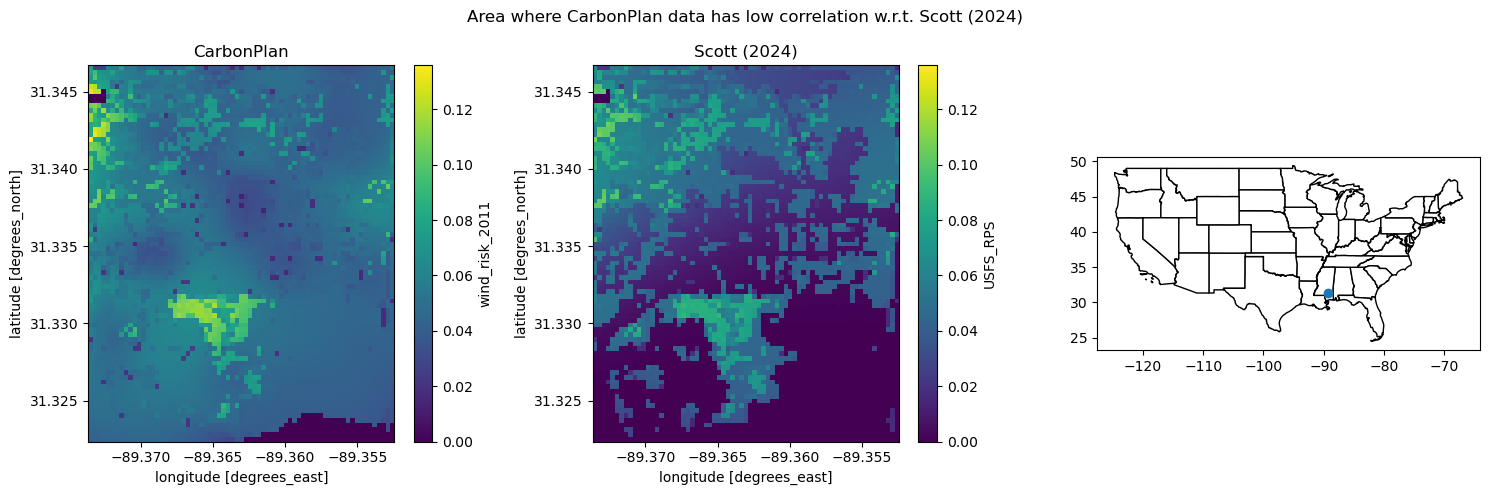

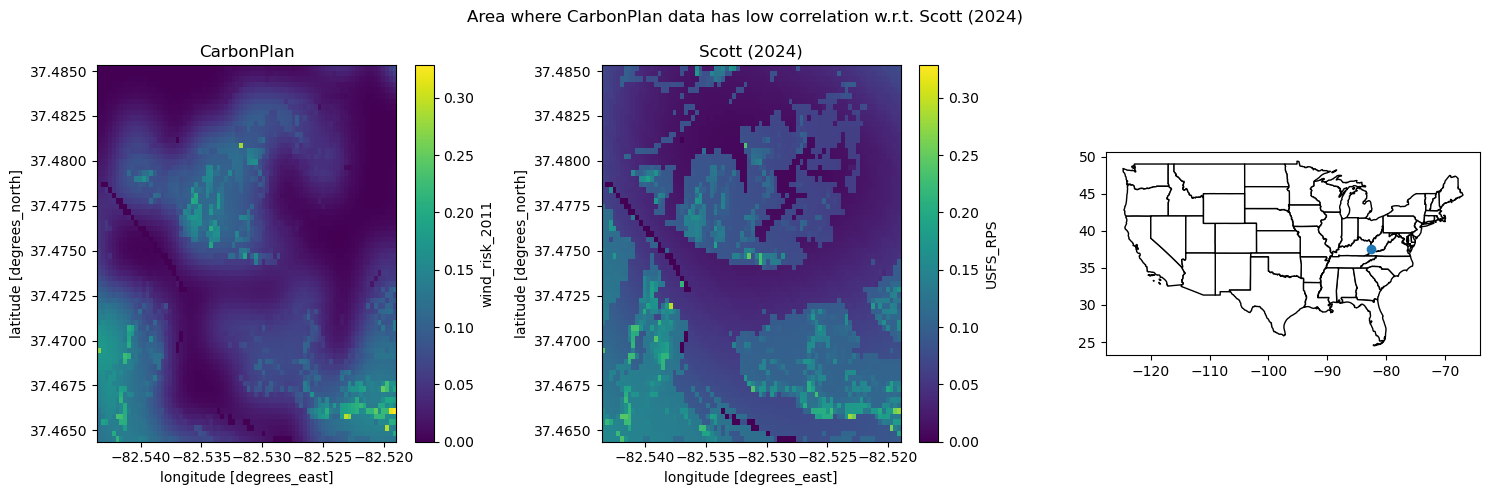

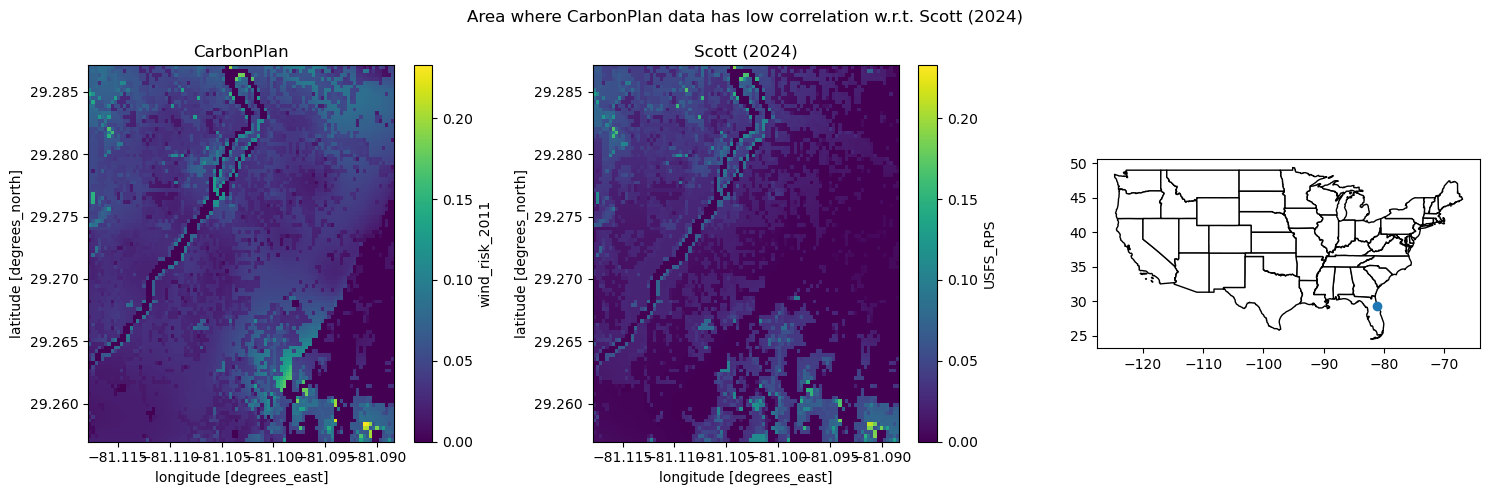

In [111]:
for statistic in ['corr_low']:
    for index in tracts_dict['corr_low'].index:
        bounds = tracts_dict['corr_low'].loc[[index]].bounds
        bounding_box = [
            slice(bounds.loc[index].maxy, bounds.loc[index].miny),
            slice(bounds.loc[index].minx, bounds.loc[index].maxx),
        ]
        plot_regions_carbonplan_scott(
            ds_dict['production'].sel(latitude=bounding_box[0], longitude=bounding_box[1]),
            bounding_box,
            f'Area where CarbonPlan data has {var_name_dict[statistic]} w.r.t. Scott (2024)',
            tracts_dict['corr_low'].loc[[index]].centroid,
        )

# High bias

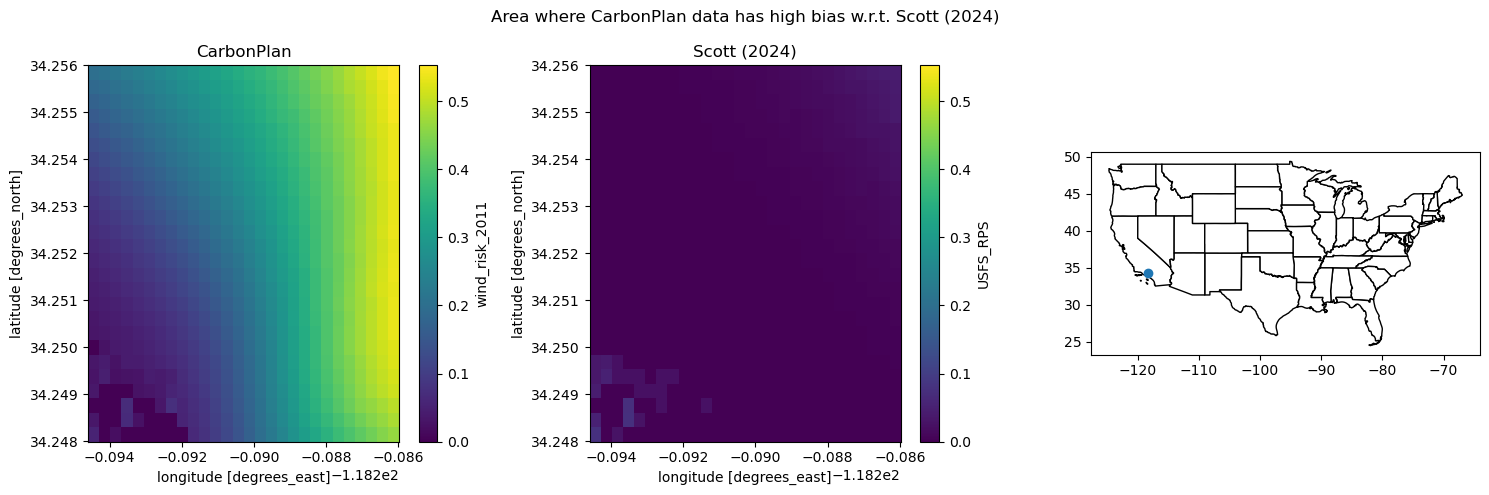

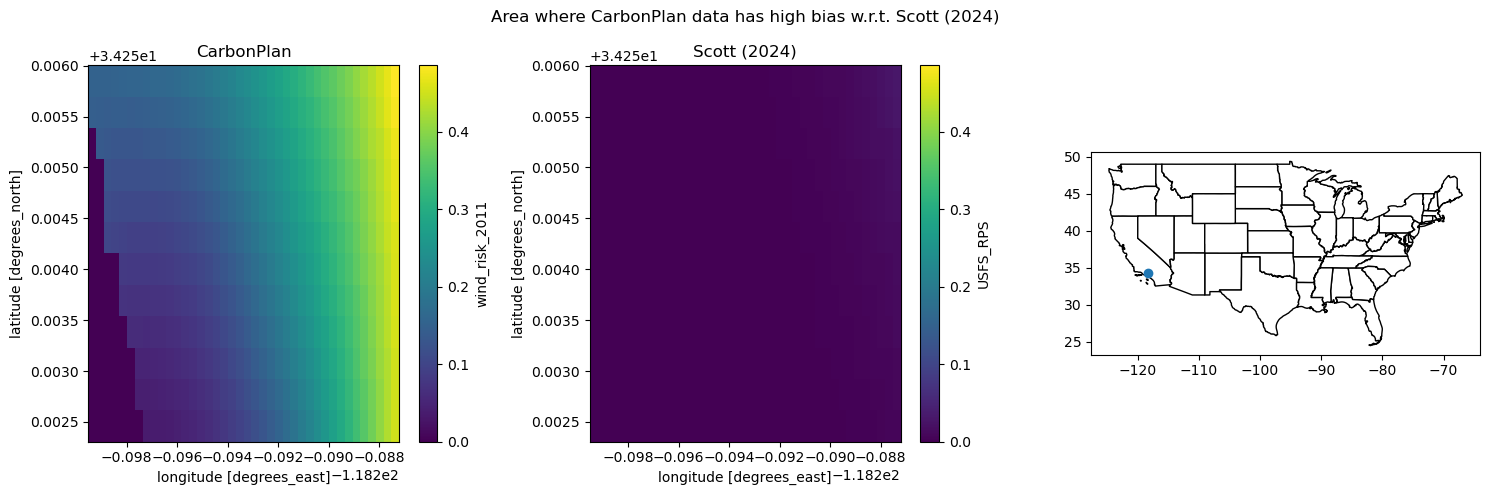

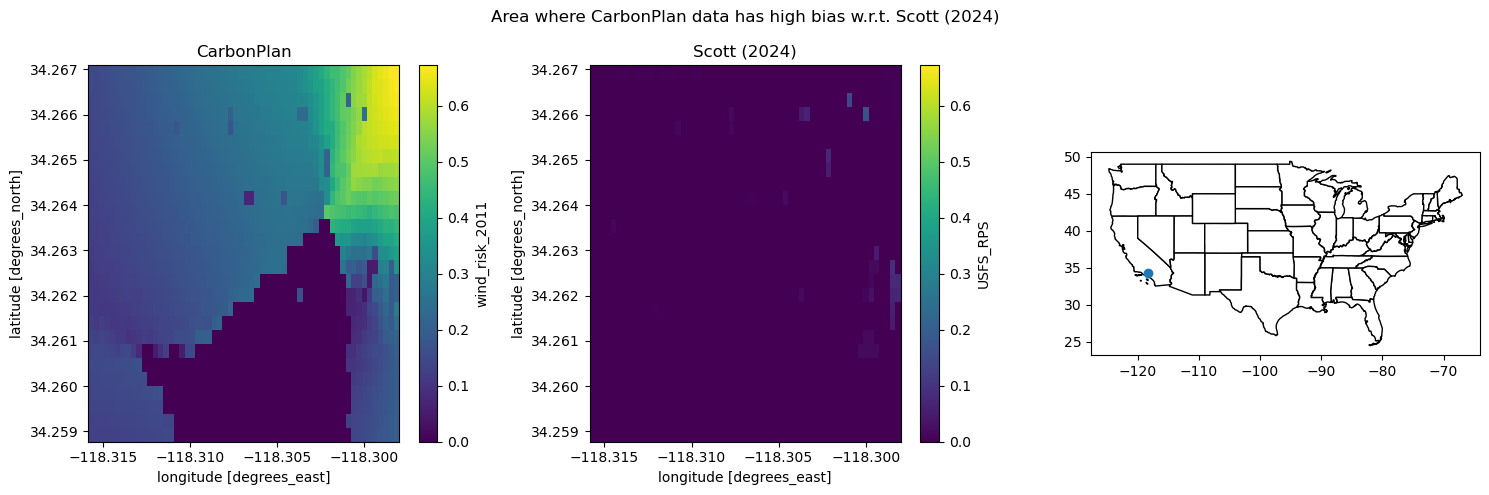

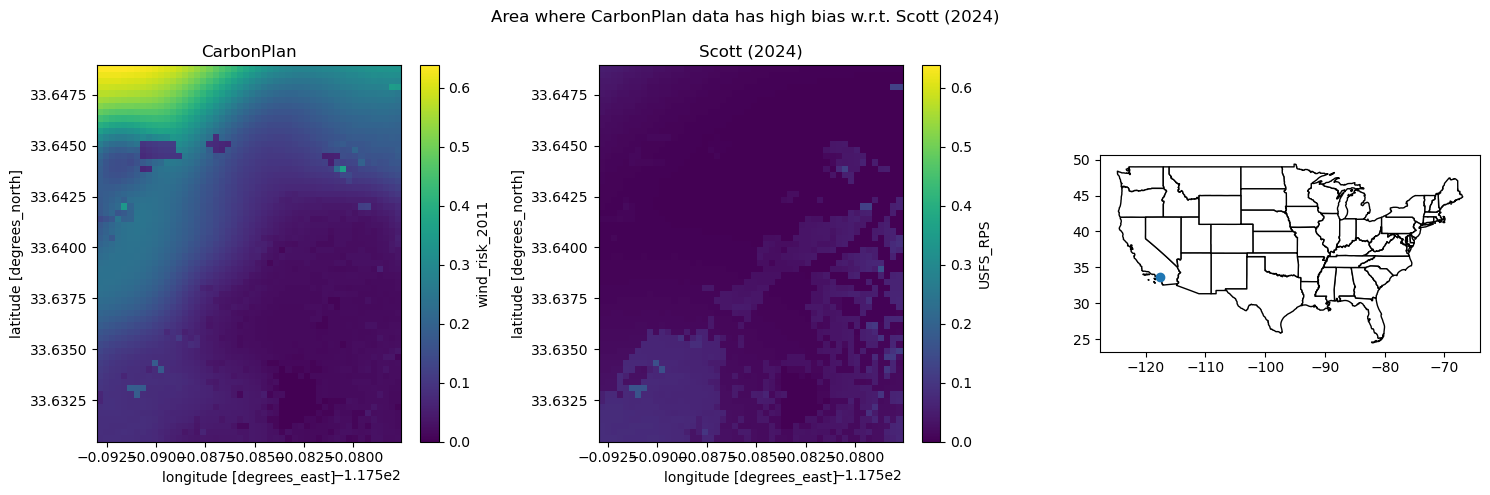

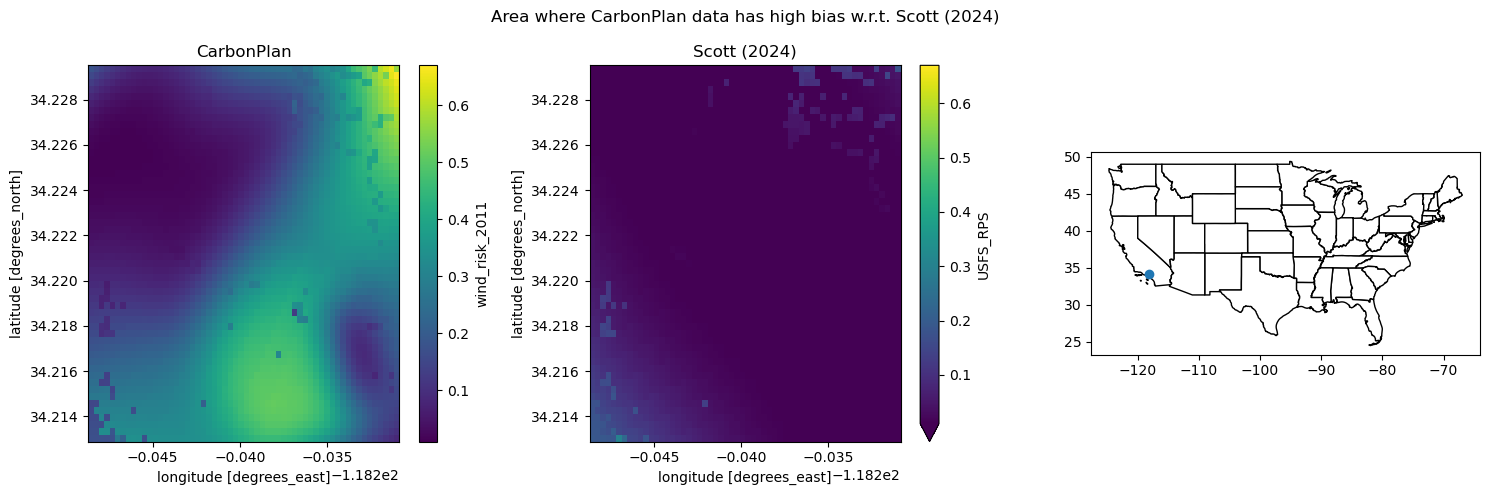

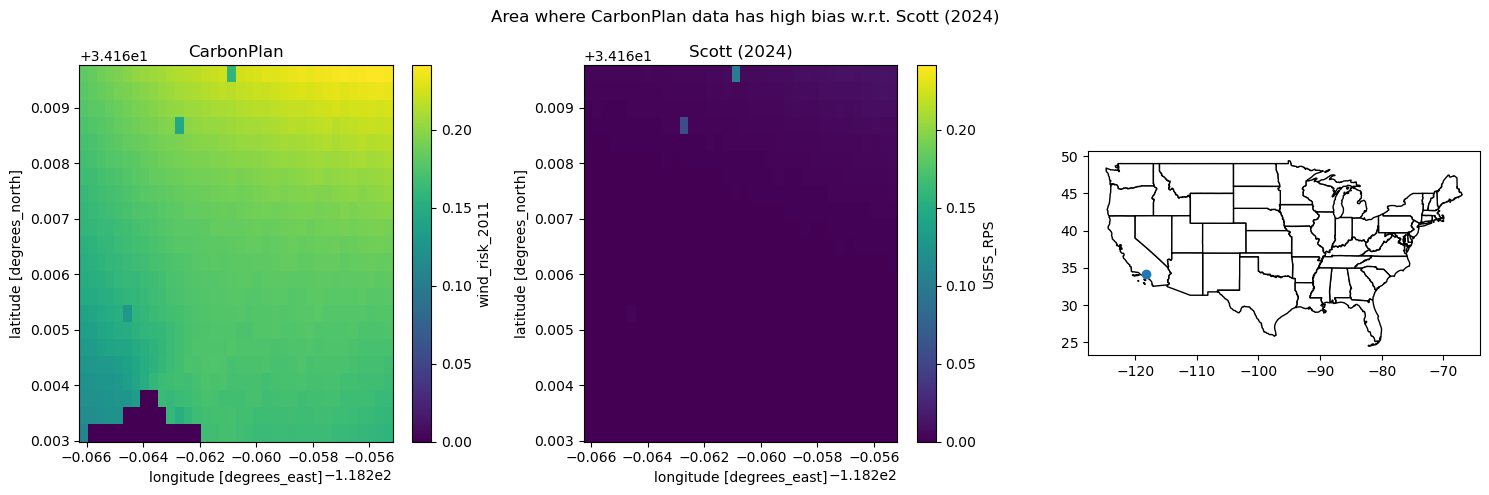

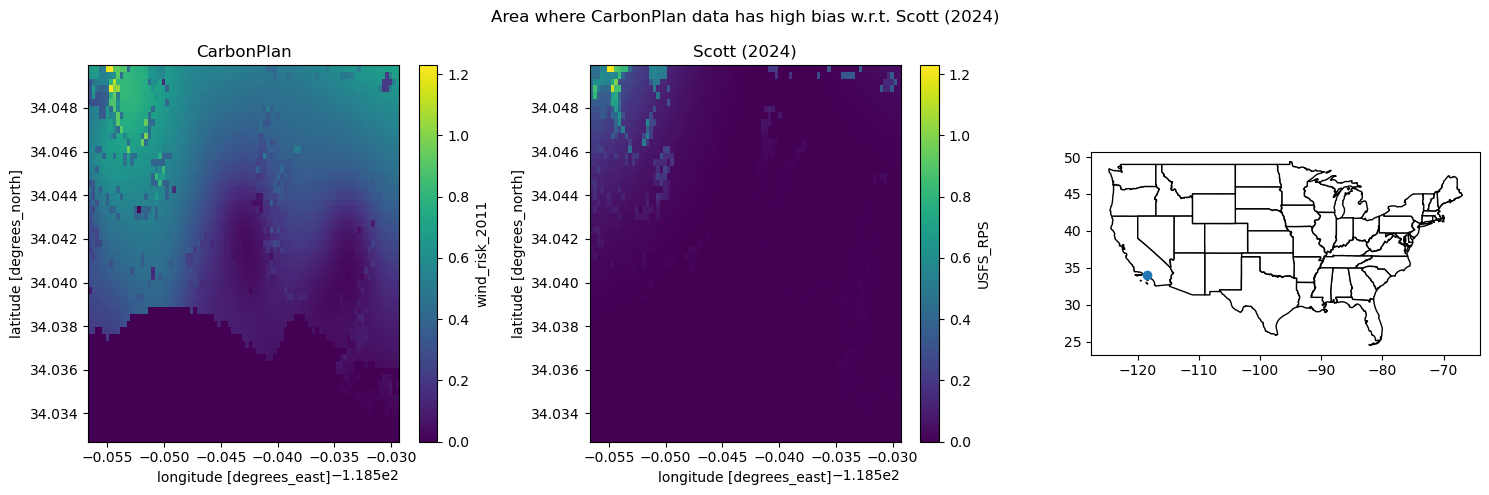

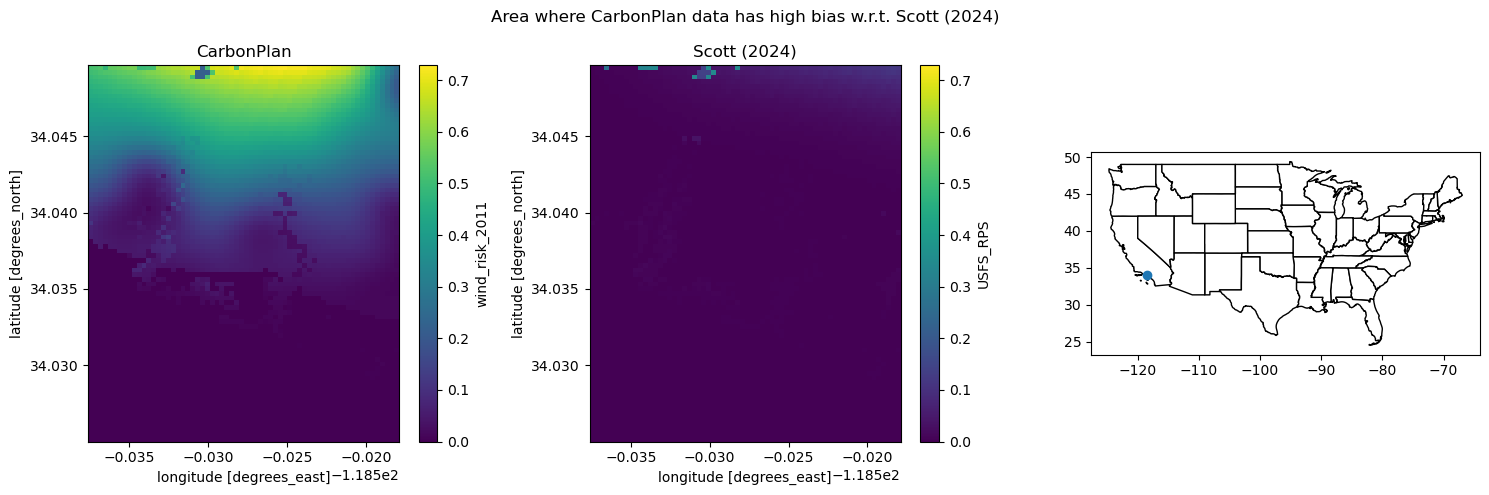

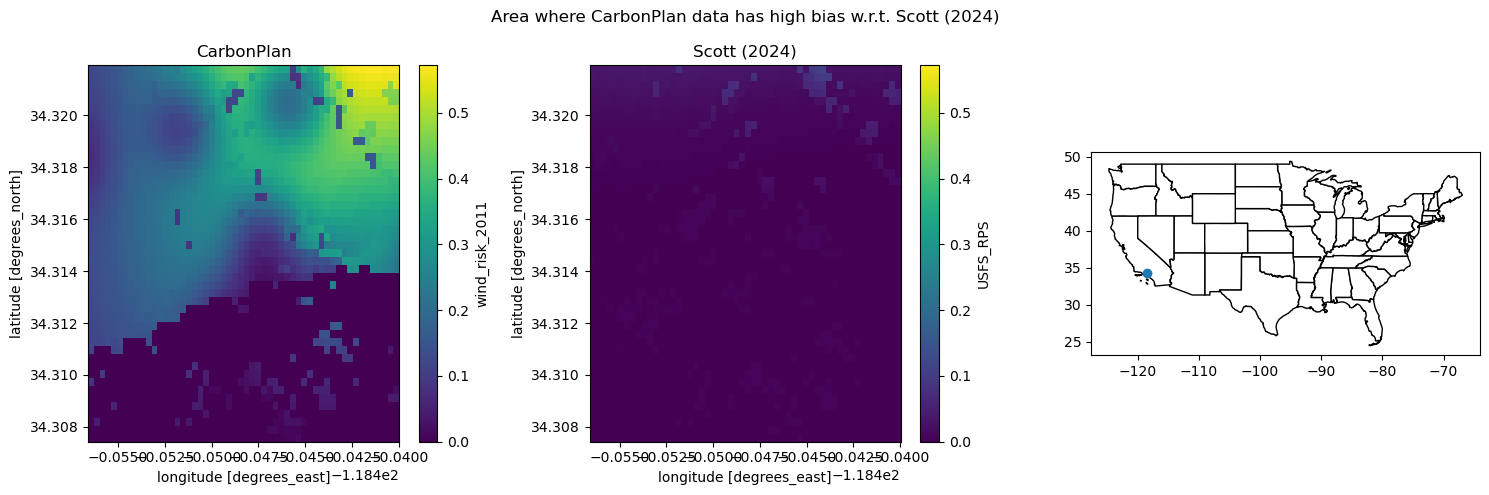

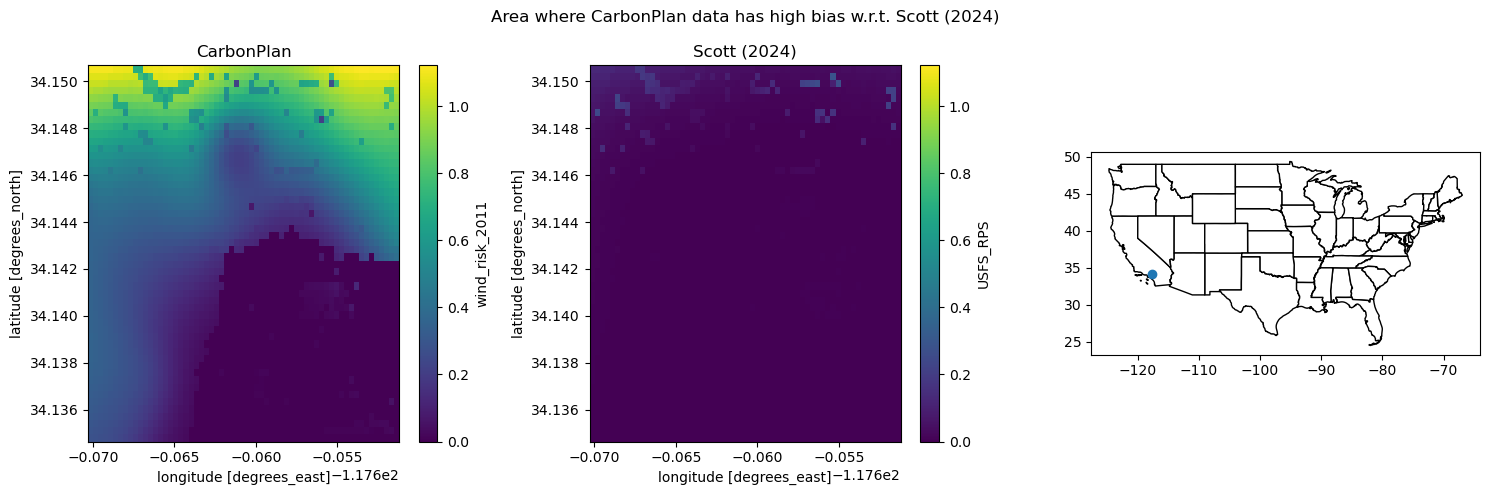

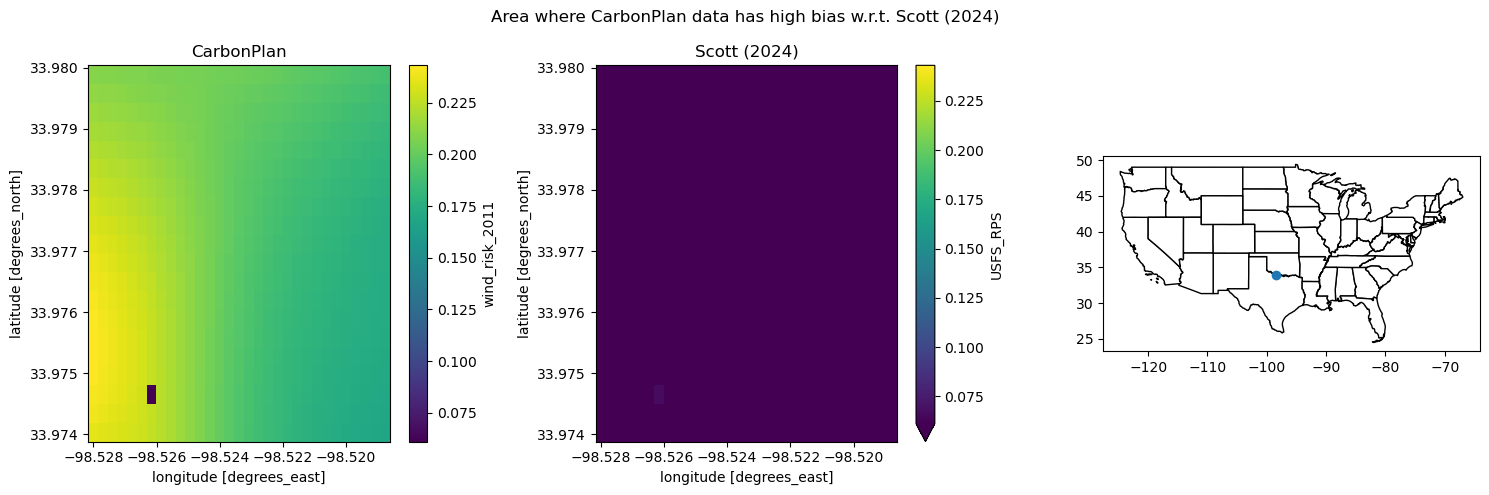

In [114]:
for statistic in ['high_bias']:
    for index in tracts_dict[statistic].index:
        bounds = tracts_dict[statistic].loc[[index]].bounds
        bounding_box = [
            slice(bounds.loc[index].maxy, bounds.loc[index].miny),
            slice(bounds.loc[index].minx, bounds.loc[index].maxx),
        ]
        plot_regions_carbonplan_scott(
            ds_dict['production'].sel(latitude=bounding_box[0], longitude=bounding_box[1]),
            bounding_box,
            f'Area where CarbonPlan data has {var_name_dict[statistic]} w.r.t. Scott (2024)',
            tracts_dict[statistic].loc[[index]].centroid,
        )

# Low bias

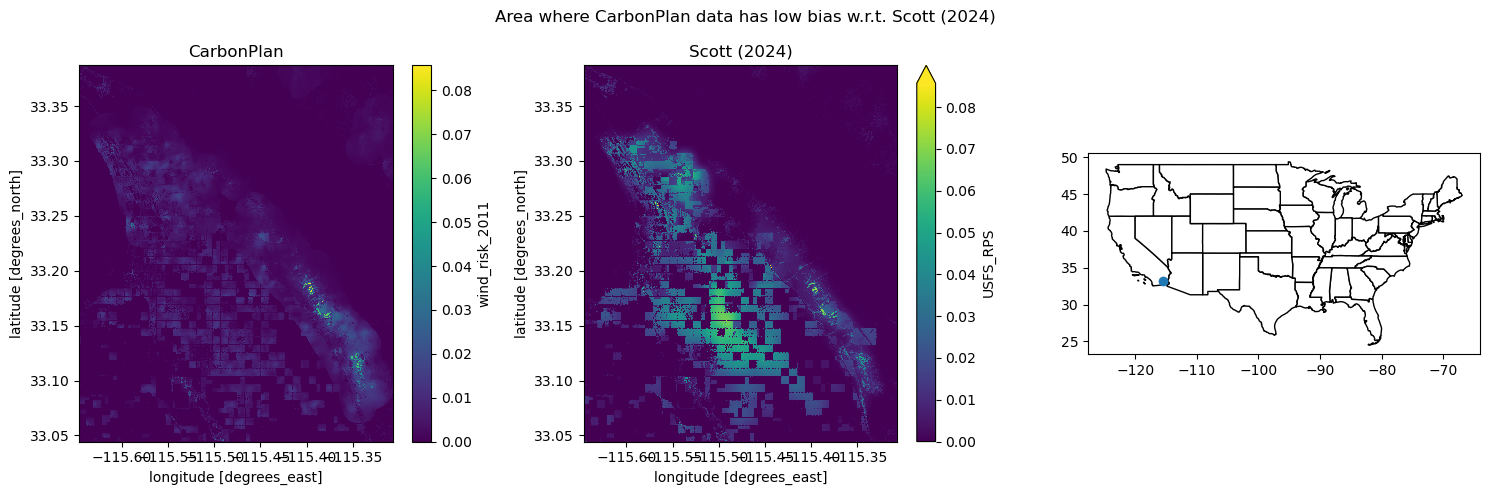

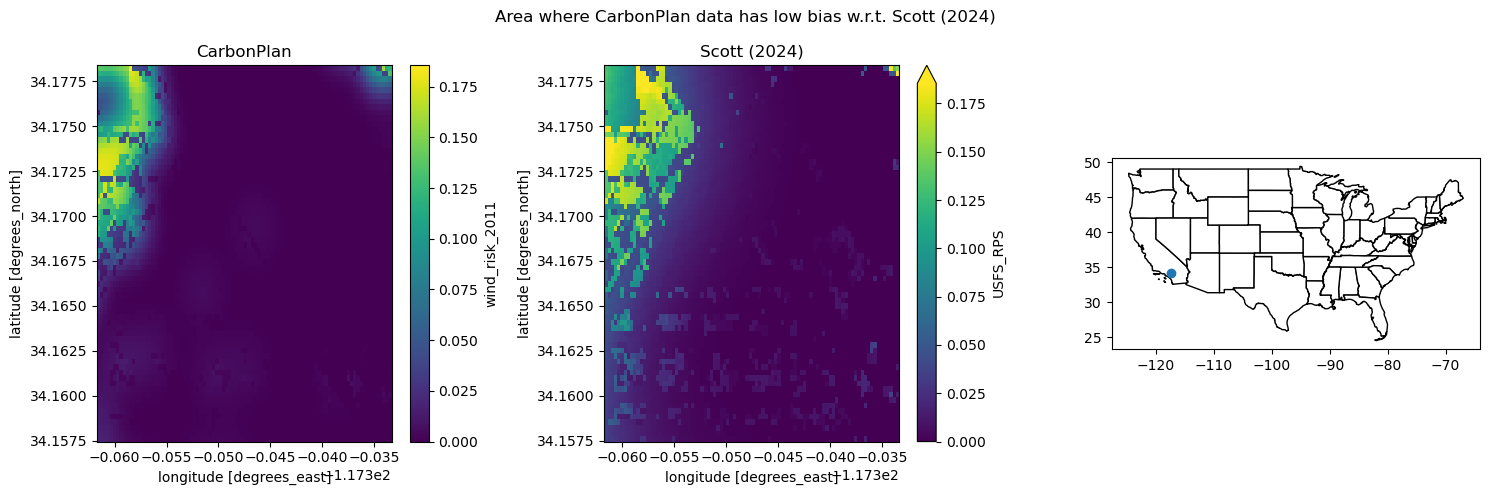

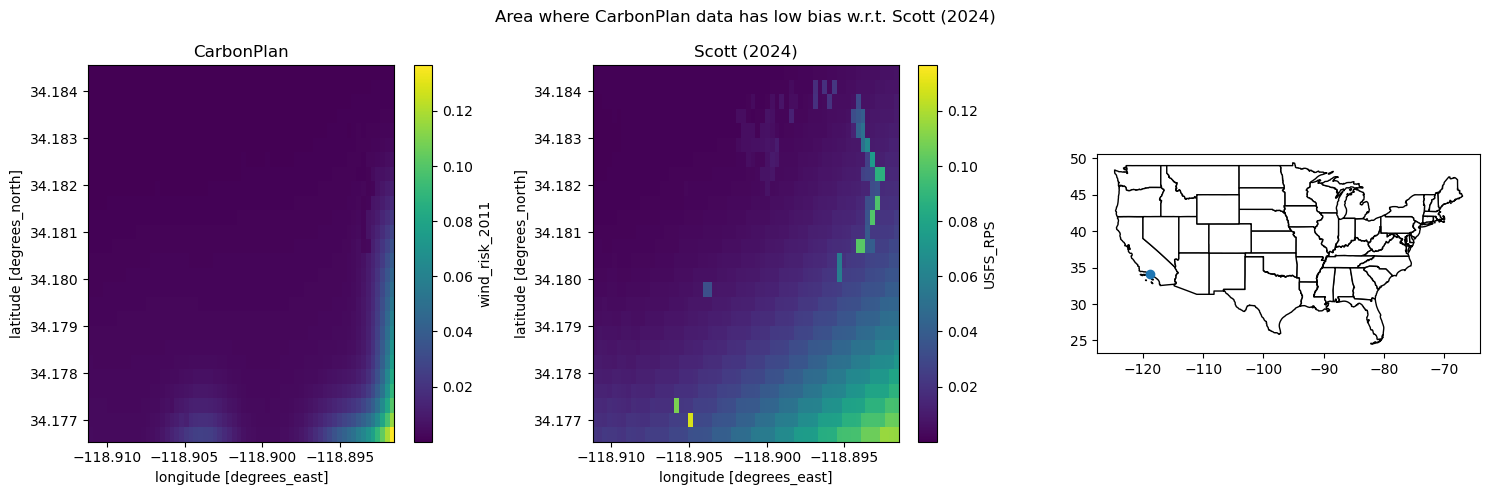

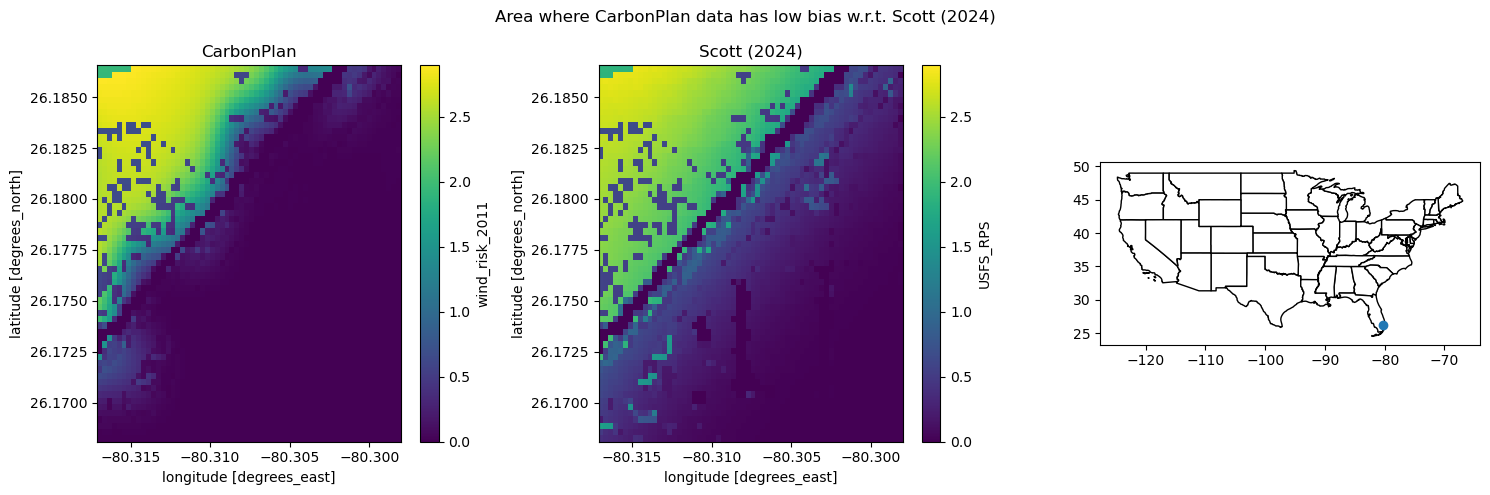

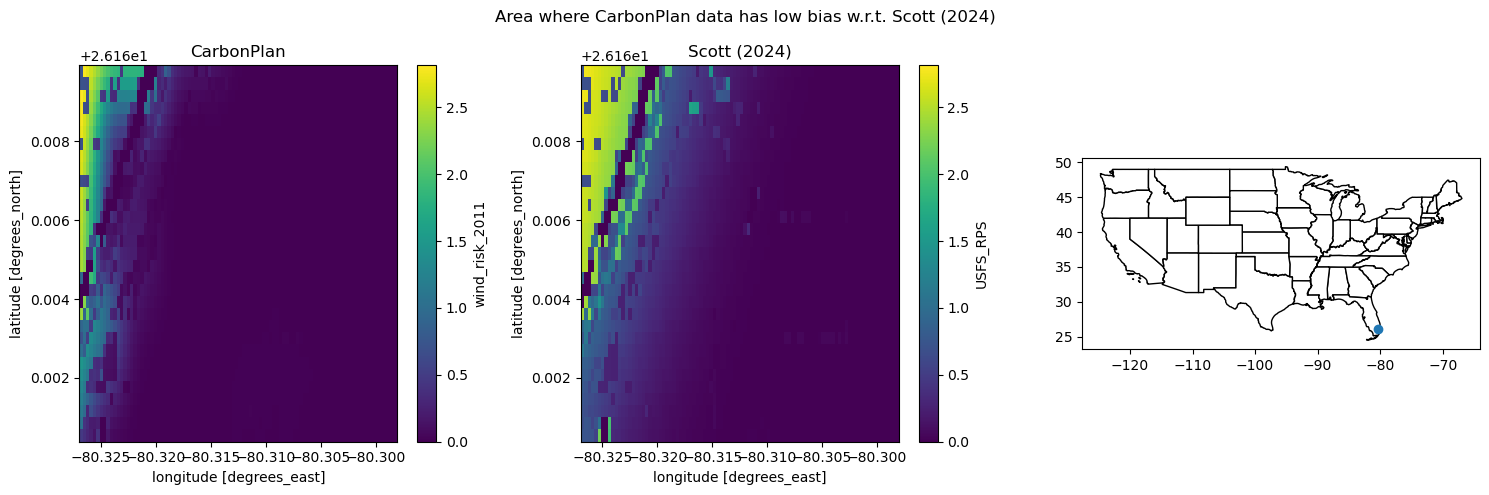

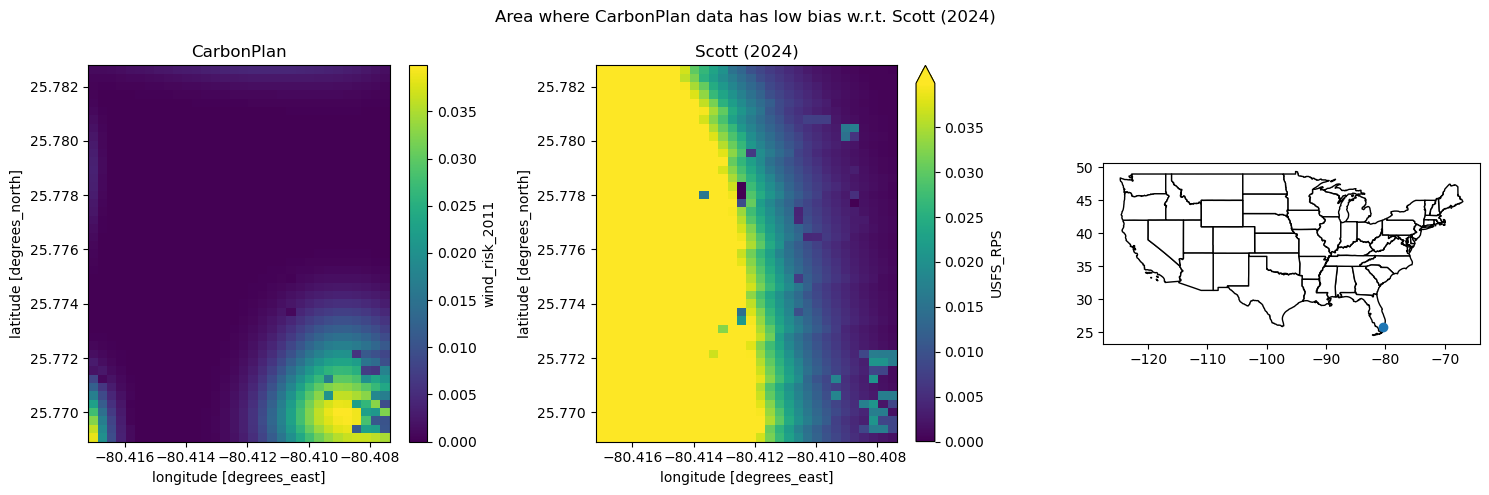

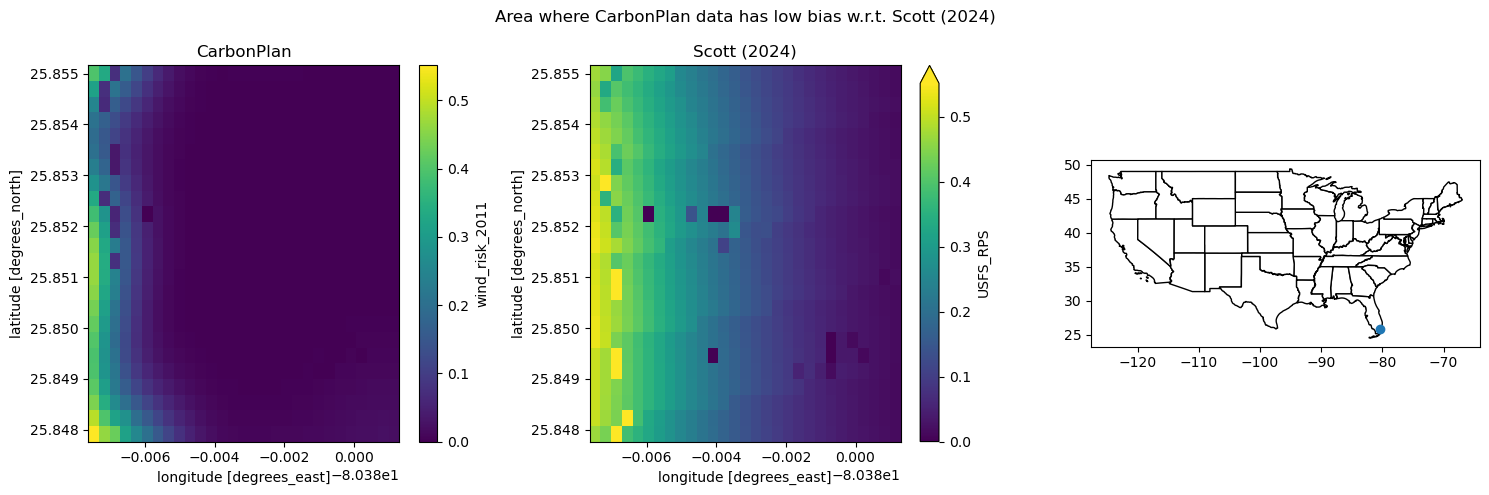

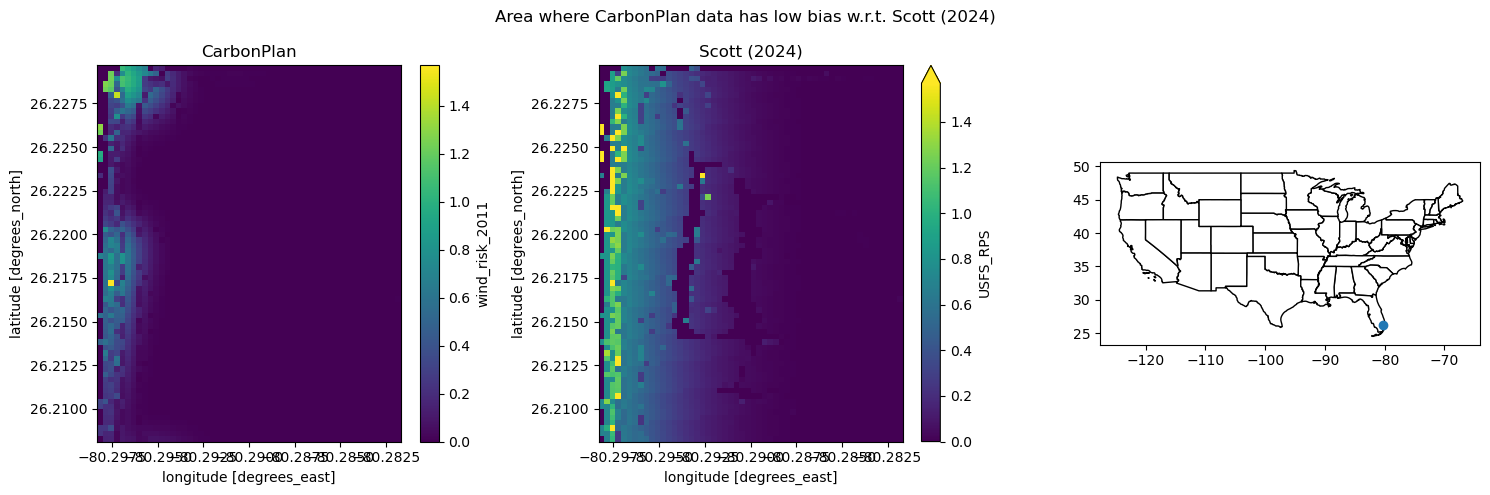

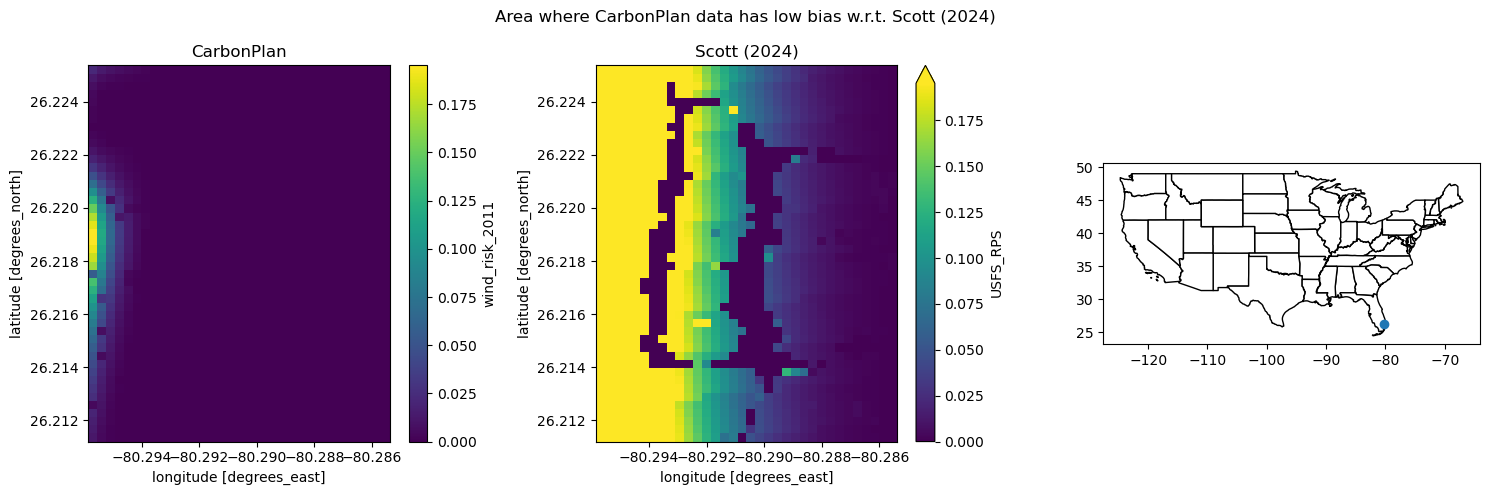

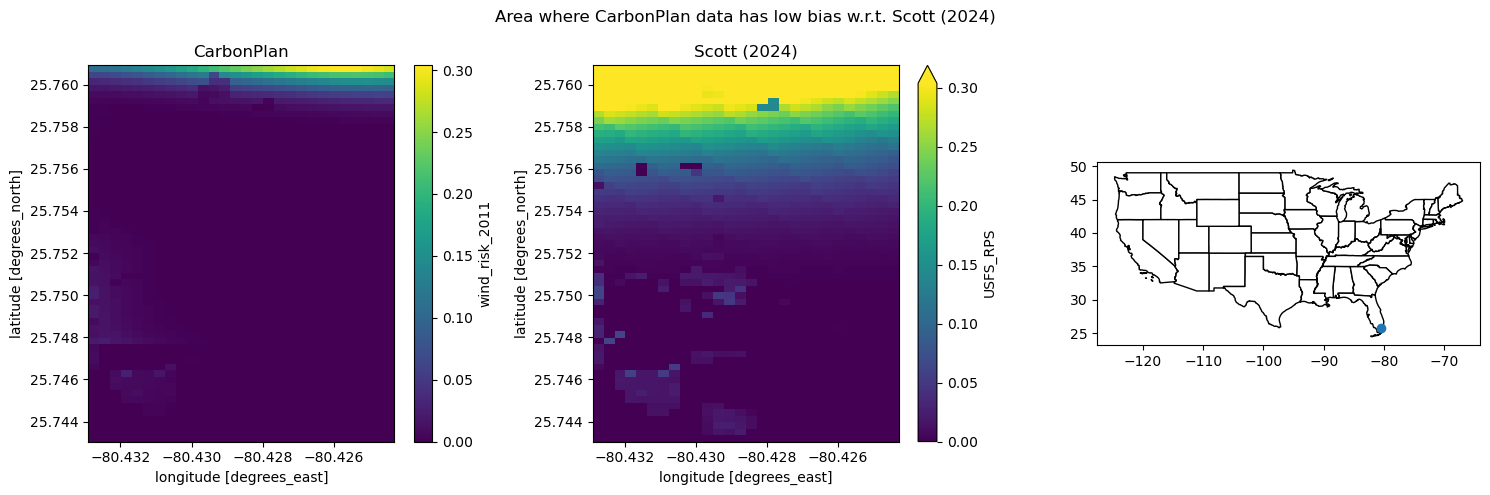

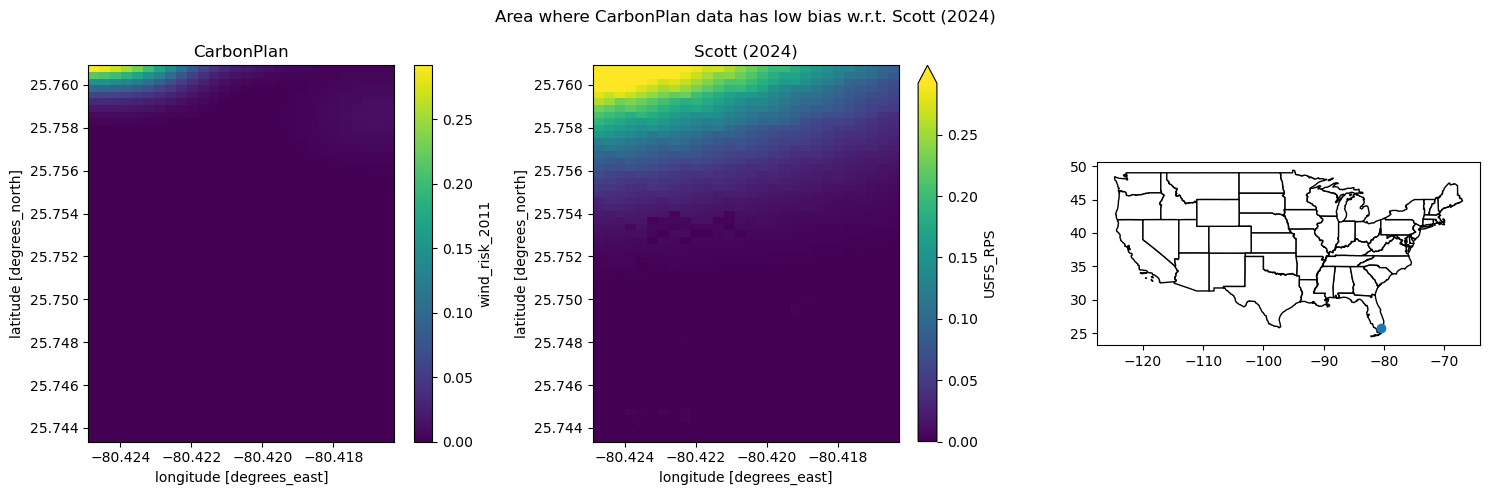

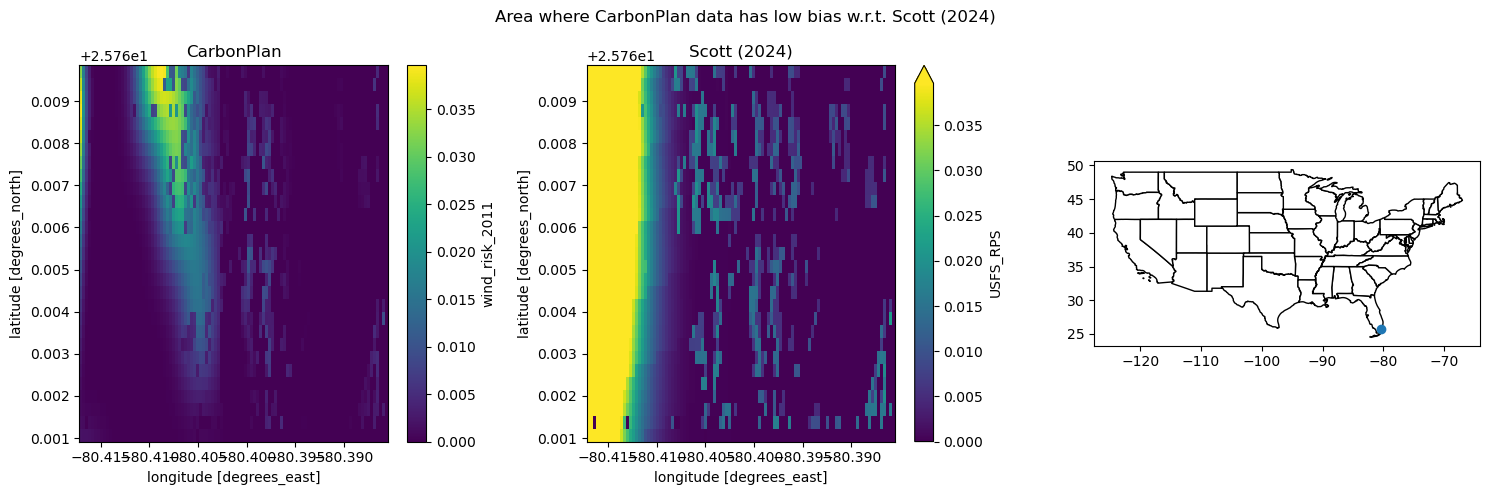

In [112]:
for statistic in ['low_bias']:
    for index in tracts_dict[statistic].index:
        bounds = tracts_dict[statistic].loc[[index]].bounds
        bounding_box = [
            slice(bounds.loc[index].maxy, bounds.loc[index].miny),
            slice(bounds.loc[index].minx, bounds.loc[index].maxx),
        ]
        plot_regions_carbonplan_scott(
            ds_dict['production'].sel(latitude=bounding_box[0], longitude=bounding_box[1]),
            bounding_box,
            f'Area where CarbonPlan data has {var_name_dict[statistic]} w.r.t. Scott (2024)',
            tracts_dict[statistic].loc[[index]].centroid,
        )

In [29]:
def plot_location(ds_dict, bounding_boxes, location):
    fig, axarr = plt.subplots(ncols=2, nrows=3, figsize=(8, 12))
    for i, (setup, ds) in enumerate(ds_dict.items()):  # , 'qa']:
        ds.sel(
            latitude=bounding_boxes[location][0], longitude=bounding_boxes[location][1]
        ).wind_risk_2011.plot(
            ax=axarr[0, i],  # vmin=0, vmax=5
        )
        axarr[0, i].set_title(setup)
        if setup == 'staging':
            ds.sel(
                latitude=bounding_boxes[location][0], longitude=bounding_boxes[location][1]
            ).USFS_RPS.plot(
                ax=axarr[1, i],  # vmin=0, vmax=5
            )
            axarr[1, i].set_title(setup)
        ds.sel(
            latitude=bounding_boxes[location][0], longitude=bounding_boxes[location][1]
        ).wind_risk_2047.plot(
            ax=axarr[2, i],  # vmin=0, vmax=5
        )
        axarr[1, i].set_title(setup)
        axarr[2, i].set_title(setup)
    for ax in axarr.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylabel('')
        ax.set_xlabel('')
    plt.tight_layout()

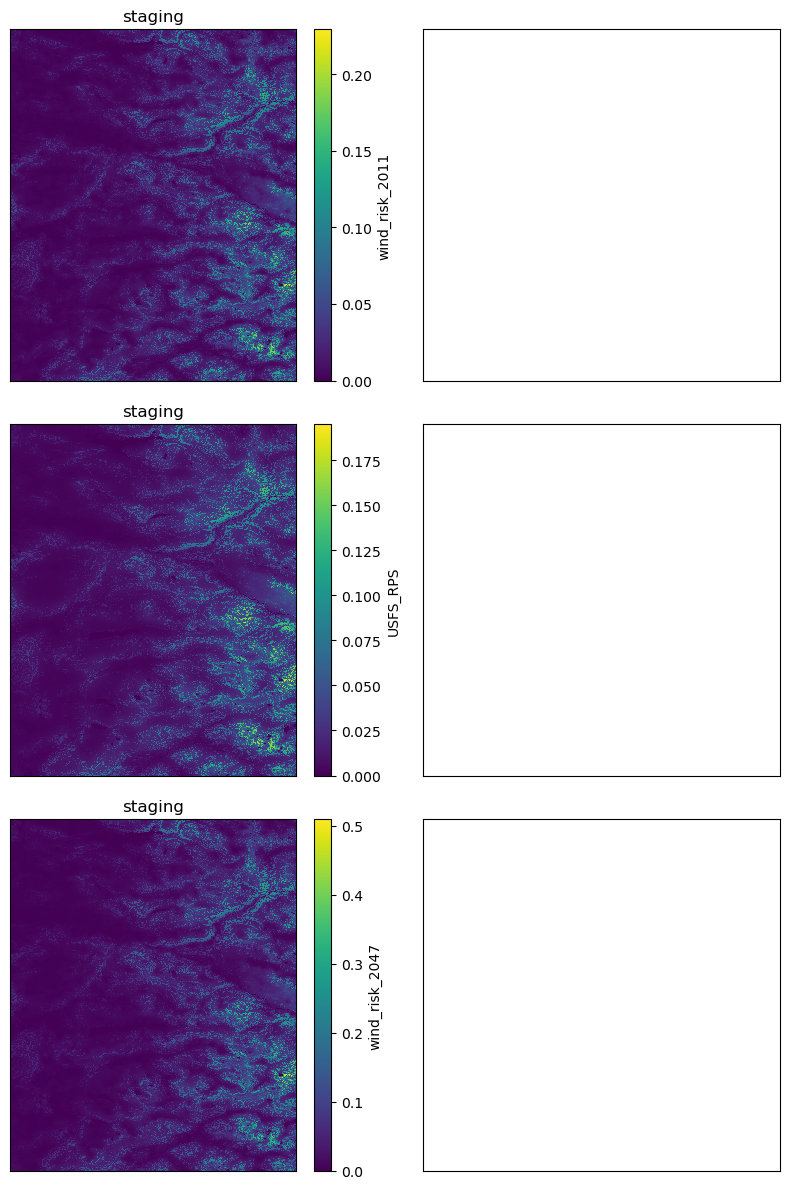

In [30]:
plot_location(ds_dict, bounding_boxes, 'bethany')

In [ ]:
plot_regions_carbonplan_scott(
    ds=ds_dict['production'].sel(latitude=bounding_box[0], longitude=bounding_box[1]),
    bounding_box=[slice(34.22, 34.15), slice(-118.18, -118.09)],
    title='Altadena',
)

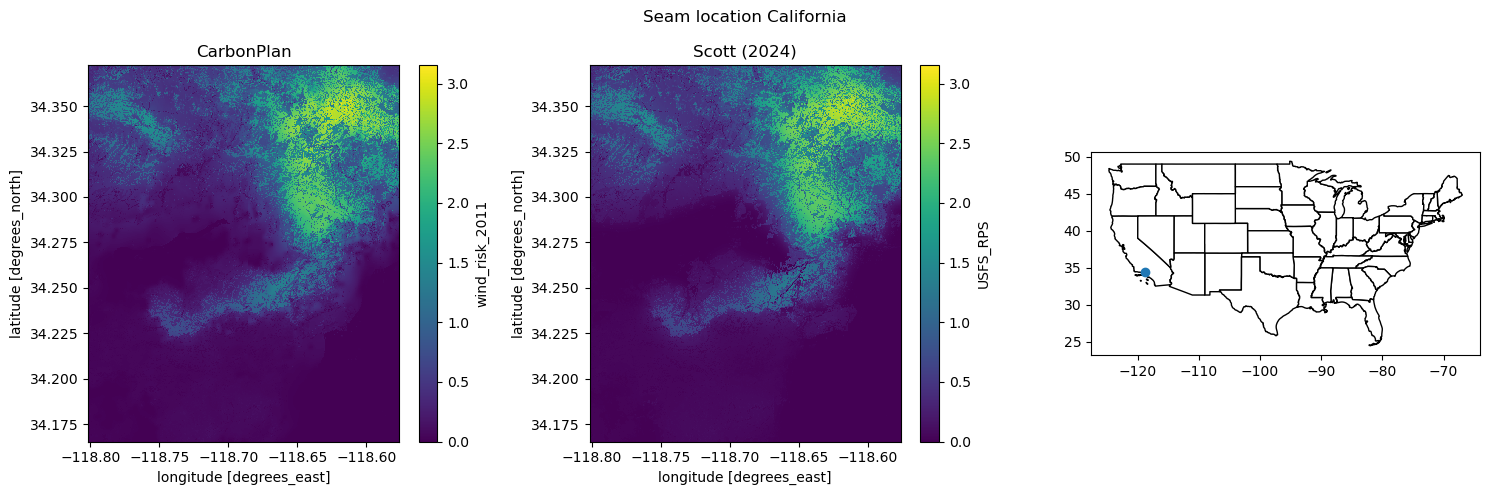

In [125]:
index = 5
bounds = tracts_dict['corr_low'].iloc[[index]].bounds
bounding_box = [
    slice(bounds.loc[index].maxy + 0.1, bounds.loc[index].miny - 0.1),
    slice(bounds.loc[index].minx - 0.1, bounds.loc[index].maxx + 0.1),
]
plot_regions_carbonplan_scott(
    ds=ds_dict['production'].sel(latitude=bounding_box[0], longitude=bounding_box[1]),
    bounding_box=bounding_box,
    title='Seam location California',
)

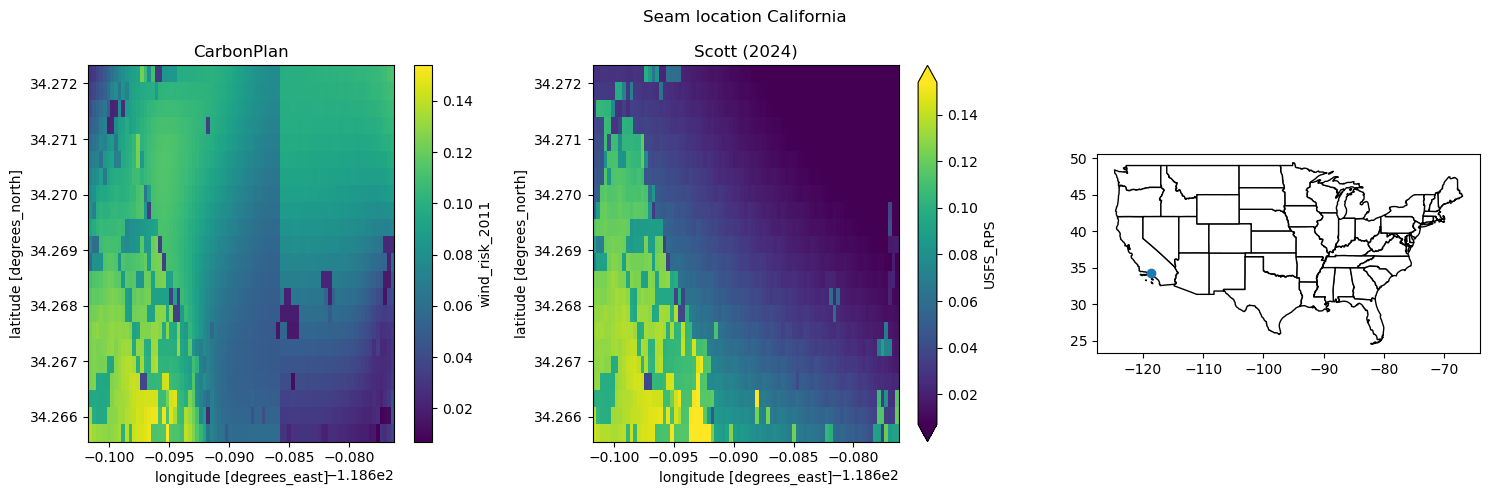

In [126]:
index = 5
bounds = tracts_dict['corr_low'].iloc[[index]].bounds
bounding_box = [
    slice(bounds.loc[index].maxy, bounds.loc[index].miny),
    slice(bounds.loc[index].minx, bounds.loc[index].maxx),
]
plot_regions_carbonplan_scott(
    ds=ds_dict['production'].sel(latitude=bounding_box[0], longitude=bounding_box[1]),
    bounding_box=bounding_box,
    title='Seam location California',
)

In [148]:
region_id = 'y9_x6'
y_slice, x_slice = config.chunking.region_id_to_latlon_slices(region_id=region_id)

In [149]:
x_slice.stop

np.float64(-118.68574904928255)

In [150]:
y_slice

slice(np.float64(35.85017945607982), np.float64(34.00221618545951), None)

In [132]:
scott = catalog.get_dataset('USFS-wildfire-risk-communities-4326').to_xarray()[
    ['BP', 'CRPS', 'RPS']
]

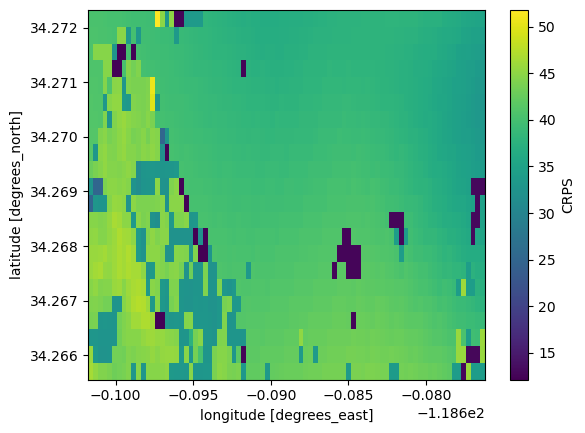

In [134]:
scott.sel(latitude=bounding_box[0], longitude=bounding_box[1]).CRPS.plot()

# Altadena

In [ ]:
bounding_box = [slice(34.22, 34.15), slice(-118.18, -118.09)]
plot_regions_carbonplan_scott(
    ds=ds_dict['production'].sel(latitude=bounding_box[0], longitude=bounding_box[1]),
    bounding_box=bounding_box,
    title='Altadena',
)